# IEEE Fraud Detection

Cette compétition est un problème de classification binaire - c'est-à-dire que notre variable cible est un attribut binaire (l'utilisateur fait-il le clic frauduleux ou non?) Et notre objectif est de classer les utilisateurs en "frauduleux" ou "non frauduleux" le mieux possible

# Package:

In [136]:
import numpy as np     
import pandas as pd   
import matplotlib.pyplot as plt   
import seaborn as sns          #version améliorée de matplotlib
import pickle as pkl
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import time
import random
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set() #pour avoir de plus beau plot

# données:

Commençons par vérifier les données submission

In [10]:
data_sub = pd.read_csv('../DataCamp/sample_submission.csv')
data_sub.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [11]:
del data_sub

On cherche à générer qu'une probabilité de transaction soit frauduleuse, indiquée par le label isFraud

On charge maintenant, les données trains et tests. Les données sont divisées en deux fichiers d'identité et de transaction

In [2]:
train_id = pd.read_csv('../DataCamp/train_identity.csv')
train_trans = pd.read_csv('../DataCamp/train_transaction.csv')
test_id = pd.read_csv('../DataCamp/test_identity.csv')
test_trans = pd.read_csv('../DataCamp/test_transaction.csv')

In [13]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [14]:
train_trans.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


On remarque que les variables ne sont pas très compréhensibles, de plus, on a énormément de NaN, cela est dû au fait, que non pas toutes les transactions ont une identité correspondante.

Essayons de calculer le nombre des NaN dans chaque variable 

**Train_identite**

In [15]:
missing_values_count = train_id.isnull().sum()
print (missing_values_count[0:15])
total_cells = np.product(train_id.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
id_10             69307
id_11              3255
id_12                 0
id_13             16913
id_14             64189
dtype: int64
% of missing data =  35.58109650830896


**Train_transaction**

In [16]:
missing_values_count = train_trans.isnull().sum()
print (missing_values_count[0:15])
total_cells = np.product(train_trans.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
dtype: int64
% of missing data =  41.073431200111266


In [17]:
print('train_transaction shape is {}'.format(train_trans.shape))
print('test_transaction shape is {}'.format(test_trans.shape))
print('train_identity shape is {}'.format(train_id.shape))
print('test_identity shape is {}'.format(test_id.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


On peut voir que les données sont assez énormes, (144233,41) pour les données d'entraintement de l'identité et (590540,394) pour les données d'entrainement des transactions. On peut aussi remarquer que les deux dataframes ont une colonne commune "TransactionID", cela nous pousse à faire une jointure des deux dataframes.

In [3]:
train = pd.merge(train_trans, train_id, on='TransactionID', how='left')
test = pd.merge(test_trans, test_id, on='TransactionID', how='left')

In [19]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


([<matplotlib.axis.XTick at 0x1a1ec6a5f8>,
 <a list of 2 Text xticklabel objects>)

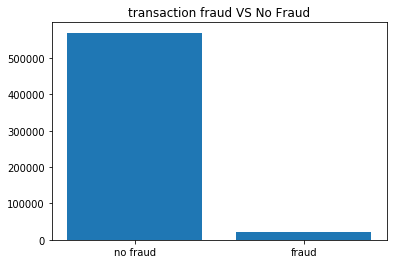

In [20]:
zero = list(train["isFraud"]).count(0)
one = list(train["isFraud"]).count(1)

label =['no fraud','fraud']
height = [zero, one]
y_pos = np.arange(len(label))
plt.bar(y_pos, height)
plt.title("transaction fraud VS No Fraud")
plt.xticks(y_pos, label)

On peut voir clairement que la plupart des transactions sont non frauduleuses. Si on utilise cette base de données comme base pour nos modèles prédictifs et nos analyses, nous pourrions obtenir beaucoup d'erreurs et nos algorithmes seront probablement trop adaptés car ils "supposeront" que la plupart des transactions ne sont pas de la fraude. Mais on ne veut pas que notre modèle suppose, nous voulons que notre modèle détecte les modèles qui donnent des signes de fraude!

In [21]:
print('train shape is {}'.format(train.shape))
print('test shape is {}'.format(test.shape))

train shape is (590540, 434)
test shape is (506691, 433)


**Réduction de mémoire** 

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
#train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 565.37 Mb (66.3% reduction)


On a concaténé "train_id" et "train_trans" en un seul dataframe appelé "train" et on a aussi fait de même pour les données de test, on peut donc, supprimer les informations supplémentaires.

In [7]:
del train_id, train_trans, test_id, test_trans

**Données "object"**

In [25]:
cat_cols = list(train.select_dtypes(include=['object']).columns)
print(cat_cols)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


Le reste des variables sont numériques.

**Nettoyage des NaN**

**Train**

In [26]:
missing_values_count = train.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

TransactionID        0
isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
card1                0
card2             8933
card3             1565
card4             1577
card5             4259
dtype: int64
% of missing data =  45.074371905803936


On peut voir que 45% des données du train sont des valeurs manquantes, nettoyons tout ça !

In [27]:
def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    return many_null_cols

In [28]:
data_null = get_too_many_null_attr(train)

In [29]:
def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols

In [30]:
get_too_many_repeated_val(train)

['isFraud',
 'dist2',
 'C3',
 'D7',
 'V98',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V129',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V281',
 'V284',
 'V286',
 'V290',
 'V293',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V300',
 'V301',
 'V305',
 'V309',
 'V311',
 'V316',
 'V318',
 'V319',
 'V320',
 'V321',
 'id_07',
 'id_08',
 'id_18',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27']

In [31]:
def get_useless_columns(data):
    too_many_null = get_too_many_null_attr(data)
    print("More than 90% null: " + str(len(too_many_null)))
    too_many_repeated = get_too_many_repeated_val(data)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null + too_many_repeated))
    cols_to_drop.remove('isFraud')
    return cols_to_drop

In [32]:
cols_to_drop = get_useless_columns(train)

More than 90% null: 12
More than 90% repeated value: 67


In [33]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: id_03, dtype: float64

On peut voir que 88% des données sont des NaN, et 10% sont des valeurs nulles. Soit 98% des données sont des valeurs manquantes, donc inutiles !

In [185]:
#with open('train.pkl', 'wb') as f:
#    pkl.dump(train, f)
#    f.close()
    
#with open('test.pkl', 'wb') as f:
#    pkl.dump(test, f)
#    f.close()

In [96]:
with open('train.pkl', 'rb') as f:
    train = pkl.load(f)
    f.close()

In [97]:
train.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### récupère le nom des colonnes dont le type est n'est pas un string afin d'avoir une matrice que numérique

In [98]:
col_num = [i for i in train.columns if type(train[i].dropna().iloc[1])!=str]

In [99]:
X = train[col_num]
X = X.fillna(X.median())

# Regression logistique

In [100]:
Y = train["isFraud"] 
X = X.loc[:, X.columns != "isFraud"]

#### Split nos données en train(67%) et test(33%)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [102]:
def temps(second):
    m, s = divmod(second, 60)
    h, m = divmod(m, 60)
    print("temps :",'{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s))

### Regression logistique avec toutes nos varibales numériques

In [103]:
tstart = time.time()
log = LogisticRegression(random_state=0).fit(X_train, y_train)
pred_train = log.predict_proba(X_train)
print("score auc train :",roc_auc_score(y_train, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

score auc train : 0.5936519820739379
temps : 00:00:51


In [104]:
tstart = time.time()
pred = log.predict_proba(X_test)
print("score auc test :",roc_auc_score(y_test, pred[:, 1]))
tend = time.time()
temps(tend-tstart)

score auc test : 0.6000045352220249
temps : 00:00:02


## Regression logistique avec cross validation

### cross validation sur toutes nos données numériques

In [33]:
tstart = time.time()
clf = LogisticRegression(random_state=0)
scores = cross_val_score(clf, X, Y, cv=5,scoring='roc_auc')
print("score auc :",scores)
tend = time.time()
temps(tend-tstart)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

score auc : [0.66496515 0.65204742 0.62923394 0.68145167 0.6253874 ]
temps : 00:08:08


## One hot incoding  et label encoding

In [105]:
def onehot(col,col_name):    
    data = np.array(col.fillna(col.mode()[0]))
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(data)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    name = [col_name+str(i) for i in range(onehot_encoded.shape[1])]
    onehot_encoded = pd.DataFrame(onehot_encoded,columns=name)
    return (onehot_encoded)

In [106]:
X_non_num = train[train.columns[~train.columns.isin(col_num)]]
X_non_num.head(5)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,...,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [11]:
card4 = onehot(train["card4"],"card4")
email = onehot(train["P_emaildomain"],"P_emaildomain")

In [12]:
 email_label= labelencod(train["P_emaildomain"],"P_emaildomain")
 card4_label = labelencod(train["card4"],"card4")

In [52]:
X_card_mail = X.join(card4).join(email)
X_card_mail.shape

(590540, 467)

In [53]:
X_card_mail_label = X.join(card4_label).join(email_label)
X_card_mail_label.shape

(590540, 404)

### cross validaiton avec nos données numérique et celles obtenus par le one hot encoding pour les variables "card4" et "P_emaildomain"

In [40]:
tstart = time.time()
clf = LogisticRegression(random_state=0)
scores_card4_email = cross_val_score(clf, X_card_mail, Y, cv=5,scoring='roc_auc')
print("score auc :",scores_card4_email)
tend = time.time()
temps(tend-tstart)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

score auc : [0.70383302 0.55383576 0.64811841 0.72185969 0.69374963]
temps : 00:09:05


On peut constater que l'on obtient un auc de 0.7218 qui est le plus élevé obtenu jusqu'à présent 

In [209]:
tstart = time.time()
clf = LogisticRegression(random_state=0)
scores_card4_email_label = cross_val_score(clf, X_card_mail_label, Y, cv=5,scoring='roc_auc')
print("score auc :",scores_card4_email_label)
tend = time.time()
temps(tend-tstart)

score auc : [0.64524952 0.67346812 0.61058545 0.63717639 0.70243953]
temps : 00:09:46


## Retranchons nous sur des données moindres

In [12]:
len(train[train["isFraud"]==1])/len(train)

0.03499000914417313

Seulement 3,49% des données sont des fraudes.

In [25]:
60000*0.0349

2094.0

In [26]:
60000-2094

57906

In [27]:
random.seed(2)
train_sample0 = train[train["isFraud"]==0].sample(n=57906)
train_sample1 = train[train["isFraud"]==1].sample(n=2094)
train_sample = train_sample0.append(train_sample1)

In [28]:
X_sample = train_sample[col_num]
Y_sample = train_sample["isFraud"] 
X_sample = X_sample.loc[:, X_sample.columns != "isFraud"]
X_sample = X_sample.fillna(X_sample.median())

In [29]:
tstart = time.time()
clf = LogisticRegression(random_state=0)
scores_sample = cross_val_score(clf, X_sample, Y_sample, cv=5,scoring='roc_auc')
print("score auc :",scores_sample)
tend = time.time()
temps(tend-tstart)

score auc : [0.66384263 0.54676092 0.59179188 0.59888089 0.63291094]
temps : 00:00:29


In [30]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', random_state=0)
scores_sample = cross_val_score(clf, X_sample, Y_sample, cv=5,scoring='roc_auc')
print("score auc :",scores_sample)
tend = time.time()
temps(tend-tstart)

score auc : [0.83455873 0.83058149 0.835763   0.83465181 0.82403719]
temps : 00:17:31


Les auc obtenu avec une penalty l1 sont bien meilleurs que ceux obtenus prédédement. Toutefois, nous travaillons que sur 60000 données. Le temps de d'exécution est en revanche bien plus grand avec cette méthodes.

In [31]:
20000*0.0349

698.0

In [32]:
20000-698

19302

In [107]:
random.seed(2)
train_sub0 = train[train["isFraud"]==0].sample(n=19302)
train_sub1 = train[train["isFraud"]==1].sample(n=698)
train_sub = train_sub0.append(train_sub1)
X_sub = train_sub[col_num]
Y_sub = train_sub["isFraud"] 
X_sub = X_sub.loc[:, X_sub.columns != "isFraud"]
X_sub = X_sub.fillna(X_sub.median())

In [34]:
tstart = time.time()
clf = LogisticRegression(random_state=0)
scores_sub = cross_val_score(clf, X_sub, Y_sub, cv=5,scoring='roc_auc')
print("score auc :",scores_sub)
tend = time.time()
temps(tend-tstart)

score auc : [0.63243793 0.64790395 0.58923945 0.52675849 0.75320759]
temps : 00:00:09


In [215]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', random_state=0)
scores_sub = cross_val_score(clf, X_sub, Y_sub, cv=5,scoring='roc_auc')
print("score auc :",scores_sub)
tend = time.time()
temps(tend-tstart)

score auc : [0.83533421 0.82105921 0.83040658 0.84203947 0.831975  ]
temps : 00:12:20


ajouter C = 1/alpha et tester

In [108]:
col_non_num = X_non_num.columns

In [95]:
'''
n=len(corr.columns)
for i in range(n):
    for j in range(i+1,n):
        if corr.iloc[i,j]>0.7:
            print(i,j)  
            
from sklearn.preprocessing import StandardScaler
data = X_sub_label
scaler = StandardScaler()
test = scaler.fit_transform(data)
'''

'\nn=len(corr.columns)\nfor i in range(n):\n    for j in range(i+1,n):\n        if corr.iloc[i,j]>0.7:\n            print(i,j)  \n            \nfrom sklearn.preprocessing import StandardScaler\ndata = X_sub_label\nscaler = StandardScaler()\ntest = scaler.fit_transform(data)\n'

In [109]:
X_sub_ohe = X_sub.reset_index(drop=True)
for i in col_non_num:
    X_sub_ohe = X_sub_ohe.join(onehot(train_sub[i],i))

In [110]:
print(X_sub_ohe.shape)

(20000, 1258)


colonnes 1258

In [111]:
X_sub_ohe.head(5)

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,DeviceInfo441,DeviceInfo442,DeviceInfo443,DeviceInfo444,DeviceInfo445,DeviceInfo446,DeviceInfo447,DeviceInfo448,DeviceInfo449,DeviceInfo450
0,3420837,10966514,312.000000,7585,553.0,150.0,226.0,181.0,87.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3200096,4940273,16.953125,3679,555.0,150.0,224.0,444.0,87.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3023286,880311,554.000000,6481,111.0,150.0,226.0,337.0,87.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3274512,7070546,1344.000000,17188,321.0,150.0,226.0,299.0,87.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3055376,1545165,57.937500,1804,161.0,150.0,117.0,269.0,87.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', random_state=0)
scores_sub_ohe = cross_val_score(clf, X_sub_ohe, Y_sub, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_ohe)
tend = time.time()
temps(tend-tstart)

score auc : [0.84088158 0.81425263 0.82512763 0.81309737 0.85029605]
temps : 00:04:28


On peut voir qu'avec le one hot encoding le temps de calcul est moindre qu'avec le label encoding. De plus, les performence au niveau de l'auc sont meilleures.

## Cross validation pour le paramètre Inverse of regularization strength

In [113]:
X_sub_ohe = X_sub.reset_index(drop=True)
for i in col_non_num:
    X_sub_ohe = X_sub_ohe.join(onehot(train_sub[i],i))

### Données centrées réduites:

In [128]:
scaler = StandardScaler()
X_sub_sc = scaler.fit_transform(X_sub_ohe)

In [129]:
X_sub_train_sc, X_sub_test_sc, y_sub_train_sc, y_sub_test_sc = train_test_split(X_sub_sc, Y_sub, test_size=0.33, 
                                                                                random_state=42)

temps : 00:19:34


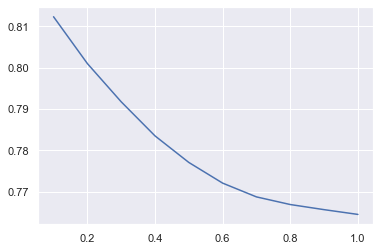

In [121]:
pred = []
tstart = time.time()
t = np.arange(0.1,1.1,0.1)
for i in t:
    if(i%2==0): print(i)
    log = LogisticRegression(solver ='liblinear', penalty = 'l1', C=i, random_state=0).fit(X_sub_train_sc, 
                                                                                           y_sub_train_sc)
    pred_train = log.predict_proba(X_sub_test_sc)
    pred.append(roc_auc_score(y_sub_test_sc, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

plt.plot(t,pred)

In [125]:
print("Pour C = ",t[np.argmax(pred)], " ,auc = ",np.max(pred))

Pour C =  0.1  ,auc =  0.8123231372549019


temps : 00:00:46


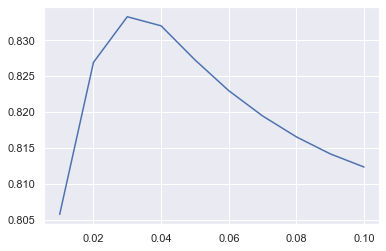

In [130]:
pred = []
tstart = time.time()
t = np.arange(0.01,0.11,0.01)
for i in t:
    if((i*10)%2==0): print(i)
    log = LogisticRegression(solver ='liblinear', penalty = 'l1', C=i, random_state=0).fit(X_sub_train_sc, 
                                                                                           y_sub_train_sc)
    pred_train = log.predict_proba(X_sub_test_sc)
    pred.append(roc_auc_score(y_sub_test_sc, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

plt.plot(t,pred)

In [131]:
print("Pour C = ",t[np.argmax(pred)], " ,auc = ",np.max(pred))

Pour C =  0.03  ,auc =  0.8332660566448801


In [138]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', C=0.03, penalty = 'l1', random_state=0)
scores_sub_sc = cross_val_score(clf, X_sub_sc, Y_sub, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_sc)
tend = time.time()
temps(tend-tstart)

score auc : [0.81386761 0.81867947 0.83385085 0.81138033 0.85455698]
temps : 00:00:47


### Données non centrées réduites

In [140]:
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, Y_sub, test_size=0.33, random_state=42)

temps : 01:23:06


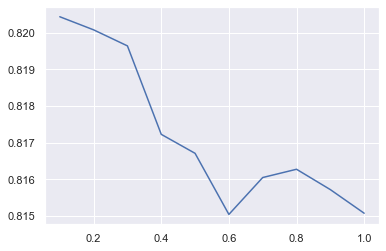

In [141]:
pred = []
tstart = time.time()
t = np.arange(0.1,1.1,0.1)
for i in t:
    if(i%2==0): print(i)
    log = LogisticRegression(solver ='liblinear', penalty = 'l1', C=i, random_state=0).fit(X_sub_train, y_sub_train)
    pred_train = log.predict_proba(X_sub_test)
    pred.append(roc_auc_score(y_sub_test, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

plt.plot(t,pred)

temps : 00:09:52


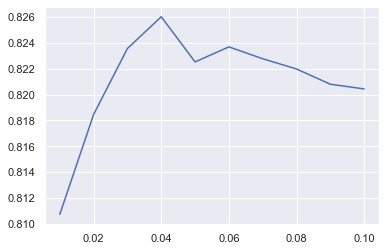

In [142]:
pred = []
tstart = time.time()
t = np.arange(0.01,0.11,0.01)
for i in t:
    if((i*10)%2==0): print(i)
    log = LogisticRegression(solver ='liblinear', penalty = 'l1', C=i, random_state=0).fit(X_sub_train, 
                                                                                           y_sub_train)
    pred_train = log.predict_proba(X_sub_test)
    pred.append(roc_auc_score(y_sub_test, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

plt.plot(t,pred)

In [143]:
print("Pour C = ",t[np.argmax(pred)], " ,auc = ",np.max(pred))

Pour C =  0.04  ,auc =  0.8260183006535948


In [144]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', C=0.04, random_state=0)
scores_sub_ohe = cross_val_score(clf, X_sub_ohe, Y_sub, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_ohe)
tend = time.time()
temps(tend-tstart)

score auc : [0.81055426 0.83288193 0.81862139 0.80513848 0.84580833]
temps : 00:06:44


In [145]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', C=1/11, random_state=0)
scores_sub_ohe = cross_val_score(clf, X_sub_ohe, Y_sub, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_ohe)
tend = time.time()
temps(tend-tstart)

score auc : [0.80764236 0.82158397 0.82255366 0.81209789 0.85299698]
temps : 00:06:56


In [147]:
pred = []
tstart = time.time()
t = np.arange(0,1.1,0.1)
for i in t:
    if((i*10)%2==0): print(i)
    log = LogisticRegression(solver ='saga', penalty = 'elasticnet', random_state=0, l1_ratio=i).fit(X_sub_train, y_sub_train)
    pred_train = log.predict_proba(X_sub_test)
    pred.append(roc_auc_score(y_sub_test, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

0.0
0.2
0.4
0.8
1.0
temps : 00:01:52


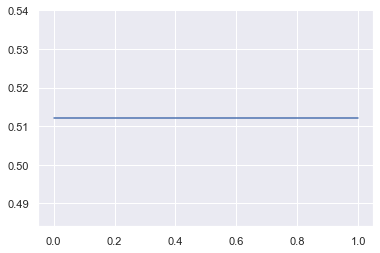

In [148]:
plt.plot(t,pred)

essayer de melanger les données (toutes les données non fraude sont en haut et fraude en bas du DataFrame)
essayer avec : df = df.sample(frac=1).reset_index(drop=True)

In [185]:
X_shuffle = X_sub_ohe.join(Y_sub.reset_index(drop=True))
X_shuffle = X_shuffle.sample(frac=1).reset_index(drop=True)

In [189]:
Y_sh = X_shuffle["isFraud"]
X_sh = X_shuffle.loc[:, X_shuffle.columns != "isFraud"]

In [190]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', C=0.04, random_state=0)
scores_sh = cross_val_score(clf, X_sh, Y_sh, cv=5,scoring='roc_auc')
print("score auc :",scores_sh)
tend = time.time()
temps(tend-tstart)

score auc : [0.81936952 0.80411255 0.81918209 0.85943639 0.83872405]
temps : 00:07:51


# Selection de variables avec Lasso

### Variables sélectionner par Lasso pour  $\lambda$=1

In [152]:
clf = linear_model.Lasso(alpha=1)
clf.fit(X_sub_ohe,Y_sub)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [153]:
coef = clf.coef_
col_ohe = X_sub_ohe.columns
var_ohe = col_ohe[coef!=0]
X_lasso = X_sub_ohe[var_ohe]

In [154]:
print(len(var_ohe))

20


Nous pouvons constater que la plupart des coefficients ont été mis à zéros

In [155]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y_sub, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

score auc : [0.69711215 0.71189551 0.69303849 0.72526932 0.73655645]
temps : 00:00:03


In [156]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y_sub, cv=10,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

score auc : [0.75086928 0.64516535 0.69766099 0.72221318 0.64618061 0.74113249
 0.73631384 0.72119171 0.7150184  0.76823609]
temps : 00:00:07


###  Variables sélectionner par Lasso pour $\lambda$ =0.1 

In [157]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_sub_ohe,Y_sub)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [158]:
coef = clf.coef_
col_ohe = X_sub_ohe.columns

In [159]:
var_ohe = col_ohe[coef!=0]
print(len(var_ohe))

67


Nous pouvons voir qu'en ce lambda le nombre de coefficient différents de ézéros à augmenter

In [160]:
X_lasso = X_sub_ohe[var_ohe]

In [167]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', C=0.04, penalty = 'l1', random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y_sub, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

score auc : [0.80981056 0.82664743 0.79449112 0.79098669 0.83188206]
temps : 00:01:06


In [168]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', C=0.04, penalty = 'l1', random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y_sub, cv=10,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

score auc : [0.83688688 0.78956869 0.80932642 0.8442339  0.75059956 0.82965211
 0.78638786 0.7888527  0.80368702 0.85972817]
temps : 00:02:21


### Variables sélectionner par Lasso pour  𝜆 =0.01

In [163]:
clf = linear_model.Lasso(alpha=0.01)
clf.fit(X_sub_ohe,Y_sub)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [164]:
coef = clf.coef_
col_ohe = X_sub_ohe.columns
var_ohe = col_ohe[coef!=0]
X_lasso = X_sub_ohe[var_ohe]

In [165]:
print(len(var_ohe))

114


Nous pouvons constater que le nombre de coefficients différents de zéros a encore augmenté

In [169]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', C=0.04, random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y_sub, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

score auc : [0.80981056 0.82664743 0.79449112 0.79098669 0.83188206]
temps : 00:01:08


In [170]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', C=0.04, random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y_sub, cv=10,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

score auc : [0.83688688 0.78956869 0.80932642 0.8442339  0.75059956 0.82965211
 0.78638786 0.7888527  0.80368702 0.85972817]
temps : 00:02:22
